## JuliaでのRunge-Kuttaの実装と速度計測


### 4次のRunge-Kuttaの復習

以下の常微分方程式
\begin{aligned}
  \frac{dy(t)}{dt} = f(t,y)
\end{aligned}
を数値的に解きたいとする。

初期条件$y(t_0)=y_0$と時間刻み幅$\Delta t$を用いて、数値的に積分したい。

4次のRunge-kuttaでは以下の更新式を用いて数値積分する。

\begin{aligned}
  y_{n+1}=y_{n}+\frac{\Delta t}{6}\left(k_{1}+2 k_{2}+2 k_{3} + k_{4}\right)
\end{aligned}

ここで、$k_1, k_2, k_3, k_4$は、

\begin{aligned}
  k_{1} &=f\left(t_{n}, y_{n}\right) \\ 
  k_{2} &=f\left(t_{n}+\frac{\Delta t}{2}, y_{n}+\frac{\Delta t}{2} k_{1}\right) \\ 
  k_{3} &=f\left(t_{n}+\frac{\Delta t}{2}, y_{n}+\frac{\Delta t}{2} k_{2}\right) \\ 
  k_{4} &=f\left(t_{n} + \Delta t, y_{n} + \Delta t k_{3}\right) 
\end{aligned}

この積分は4次精度$O(\Delta t^4)$の近似になっている。


### JuliaでのRunge-Kuttaの実装

Runge-Kuttaを使って一般的に常微分方程式を解くソルバーを実装する。


In [1]:
function rungekutta(f, y, time)
    delta_t = time[2] - time[1]
    for n in 2:size(time, 1)
        k1 = delta_t * f(time[n-1], y[:, n-1])
        k2 = delta_t * f(time[n-1] + 0.5 * delta_t, y[:, n-1] + 0.5 * k1)
        k3 = delta_t * f(time[n-1] + 0.5 * delta_t, y[:, n-1] + 0.5 * k2)
        k4 = delta_t * f(time[n-1] + delta_t, y[:, n-1] + k3)
        y[:, n] = y[:, n-1] + (1.0 / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    end
    return y
end

rungekutta (generic function with 1 method)

### Lorenzアトラクタでの例

\begin{align}
  {\frac{d x}{d t}=-p x+p y} \\
  {\frac{d y}{d t}=-x z+r x-y} \\
  {\frac{d z}{d t}=x y-b z}
\end{align}

ここで、$p=10$、$r=28$、$b=8/3$。

In [2]:
function f_lorenz(t, y)
    p = 10.0
    r = 28.0
    b = 8.0 / 3.0
    dydt = zeros(Float64, 3)
    dydt[1] = - p*y[1] + p*y[2]
    dydt[2] = - y[1]*y[3] + r*y[1] - y[2]
    dydt[3] = y[1]*y[2] - b*y[3]
    return dydt
end

f_lorenz (generic function with 1 method)

In [3]:
delta_t = 0.01
nstep = 10000
time = collect(0:delta_t:(delta_t*nstep))
y = zeros(3, size(time)[1])
y[:, 1] .= 1.0

3-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 1.0
 1.0
 1.0

In [4]:
y2 = rungekutta(f_lorenz, y, time)

3×10001 Array{Float64,2}:
 1.0  1.01257   1.04882   1.10721   …  -8.67457   -7.8401    -7.03628 
 1.0  1.25992   1.524     1.79831      -0.213188   0.368509   0.816664
 1.0  0.984891  0.973114  0.965159     35.5183    34.5767    33.6228  

In [5]:
using PyPlot

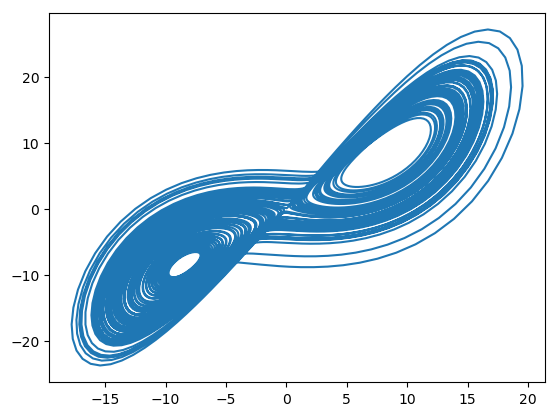

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141bcfd68>

In [6]:
plot(y[1, :], y[2, :])

In [7]:
#fig = PyPlot.plt.figure()
#ax = fig[:add_subplot](111, projection="3d")    
#ax[:plot](y[1, :], y[2, :], y[3, :])

### 実行時間の計測
Juliaでは、`%timeit`のかわりに、BenchmarkToolsの`@btime`や`@benchmark`などを使う

In [8]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1186


In [9]:
@btime y2 = rungekutta(f_lorenz, y, time)

  24.266 ms (290000 allocations: 26.55 MiB)


3×10001 Array{Float64,2}:
 1.0  1.01257   1.04882   1.10721   …  -8.67457   -7.8401    -7.03628 
 1.0  1.25992   1.524     1.79831      -0.213188   0.368509   0.816664
 1.0  0.984891  0.973114  0.965159     35.5183    34.5767    33.6228  

In [10]:
@benchmark y2 = rungekutta(f_lorenz, y, time)

BenchmarkTools.Trial: 
  memory estimate:  26.55 MiB
  allocs estimate:  290000
  --------------
  minimum time:     25.326 ms (6.25% GC)
  median time:      27.565 ms (6.39% GC)
  mean time:        28.477 ms (8.75% GC)
  maximum time:     87.004 ms (63.67% GC)
  --------------
  samples:          176
  evals/sample:     1

## もっと速くなるかの試み



In [32]:
function rungekutta2(f, y, time::Vector{Float64})
    delta_t = time[2] - time[1]
    p = 10.0
    r = 28.0
    b = 8.0 / 3.0
    dydt = zeros(Float64, 3)
    for n in 2:size(time, 1)
        @inbounds f(time[n-1], y[:, n-1], p, r, b, dydt); k1 = delta_t * dydt
        @inbounds f(time[n-1] + 0.5 * delta_t, y[:, n-1] + 0.5 * k1, p, r, b, dydt); k2 = delta_t * dydt
        @inbounds f(time[n-1] + 0.5 * delta_t, y[:, n-1] + 0.5 * k2, p, r, b, dydt); k3 = delta_t * dydt
        @inbounds f(time[n-1] + delta_t, y[:, n-1] + k3, p, r, b, dydt); k4 = delta_t * dydt
        @inbounds y[:, n] = y[:, n-1] + (1.0 / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    end
    return y
end

rungekutta2 (generic function with 1 method)

In [33]:
function f_lorenz2(t, y, p, r, b, dydt)
    dydt[1] = - p*y[1] + p*y[2]
    dydt[2] = - y[1]*y[3] + r*y[1] - y[2]
    dydt[3] = y[1]*y[2] - b*y[3]
    1.0
end

f_lorenz2 (generic function with 1 method)

In [34]:
delta_t = 0.01
nstep = 10000
time = collect(0:delta_t:(delta_t*nstep))
y = zeros(3, size(time, 1))
y[:, 1] .= 1.0

3-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 1.0
 1.0
 1.0

In [35]:
@btime rungekutta2(f_lorenz2, y, time)

  23.391 ms (250001 allocations: 22.28 MiB)


3×10001 Array{Float64,2}:
 1.0  1.01257   1.04882   1.10721   …  -8.67457   -7.8401    -7.03628 
 1.0  1.25992   1.524     1.79831      -0.213188   0.368509   0.816664
 1.0  0.984891  0.973114  0.965159     35.5183    34.5767    33.6228  